# Evaluating Cell Type Transitions

In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
import scipy
import math


import matplotlib
from scipy.spatial import cKDTree
import sys
sys.path.append('/home/icb/manuel.gander/Reproducibility_TOME/Utils')

# Utils contains some functions I use a lot
import Utils
import Map_adjustment_utils as Utils3
import Validation_utils as Utils4

#sc.settings.verbosity = 0

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,6)})

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]

# Evaluate cell type transitions

In [3]:
def load_dict(i, ts0, ts1):
    if i<13:
        eps=0.005
        suffix='giv_lam_very_small_lam'
    elif i==13:
        eps=1e-05
        suffix='full'
    elif i==14:
        eps=0.0001
        suffix='full10'
    elif i==15:
        eps=0.00001
        suffix='full'
    elif i==16:
        eps=0.0005
        suffix='full3'
    elif i==17:
        eps=0.002
        suffix='full2'
    elif i==18:
        eps=0.001
        suffix='full'

    Dict1=np.load(f"{Path}/Moscot-maps/Map_{ts0}_{ts1}_{eps}_{suffix}.npy", allow_pickle=True)
    Dict1 = dict(enumerate(Dict1.flatten(), 1))[1]
    
    return(Dict1, eps)

In [23]:
Df=pd.DataFrame({})
cutoff=0.0

for i in range(19):
    ts0=ts[i]
    ts1=ts[i+1]
        
    # The TOME cell type transition rates
    T=np.load(f'{Path}/TOME-maps/Python_TOME_transition_rates_new_emb_ideal.npy', allow_pickle=True)
    T = dict(enumerate(T.flatten(), 1))[1]
    
    Dict1,eps=load_dict(i,ts0,ts1)

    rank=500
    gam=100
    Tg=np.load(f'{Path}/moscot_lr_maps/Map_LR_{ts0}_{rank}_{gam}.npy', allow_pickle=True)
    Tg = dict(enumerate(Tg.flatten(), 1))[1]

    A=anndata.AnnData(Tg['A'])
    A.obs['cell_state_parent']=A.obs.index
    A.var['cell_state_child']=A.var.index
    A=A.T.copy()
    
    Tg=T.copy()
    Tg[ts0]=A
    Tg=Utils3.add_cell_types_ideal(Tg)
    llr=Utils4.lit_metric_t2(Tg, ts0, cutoff=cutoff)
    glr=Utils4.germ_metric_t2(Tg, ts0, cutoff=cutoff)

    TM=T.copy()
    TM[ts0]=Dict1['B']

    # Add the tranition rates for cell types that are missing for a time point
    T=Utils3.add_cell_types_ideal(T)
    TM=Utils3.add_cell_types_ideal(TM)

    T=Utils3.normalize(T)
    TM=Utils3.normalize(TM)

    Lit_eval_T=Utils4.lit_metric_t2(T, ts0, cutoff=cutoff)
    Lit_eval_M=Utils4.lit_metric_t2(TM, ts0, cutoff=cutoff)
    
    
    Germ_eval_T=Utils4.germ_metric_t2(T, ts0, cutoff=cutoff)
    Germ_eval_M=Utils4.germ_metric_t2(TM, ts0, cutoff=cutoff)


    df=pd.DataFrame({'Starting Timepoint':[ts0], 't':t[i], 'eps':eps, 'cutoff':cutoff, 
                     'TOME_lit_c': Lit_eval_T[0], 'TOME_lit_w': Lit_eval_T[1],
                     'LR_lit_c': llr[0], 'LR_lit_w': llr[1],
                     'Moscot_lit_c': Lit_eval_M[0], 'Moscot_lit_w': Lit_eval_M[1],
                     'TOME_germ_c': Germ_eval_T[0], 'TOME_germ_w': Germ_eval_T[1],
                     'Moscot_germ_c': Germ_eval_M[0], 'Moscot_germ_w': Germ_eval_M[1],
                    'LR_germ_c': glr[0], 'LR_germ_w': glr[1]})

    frames=[Df, df]
    Df=pd.concat(frames)
Df.index=np.arange(len(Df))

In [24]:
early=Df[Df['Starting Timepoint'].isin(['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25'])]
mid=Df[Df['Starting Timepoint'].isin(['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75',  'E8.0', 'E8.25', 'E8.5a'])]
end=Df[Df['Starting Timepoint'].isin(['E8.5b','E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5'])]

In [25]:
def calc_score(df,  key='lit'):
    ct=df[f'TOME_{key}_c'].sum()
    wt=df[f'TOME_{key}_w'].sum()
    rt=ct/(ct+wt)
    
    cm=df[f'Moscot_{key}_c'].sum()
    wm=df[f'Moscot_{key}_w'].sum()
    rm=cm/(cm+wm)
    
    cl=df[f'LR_{key}_c'].sum()
    wl=df[f'LR_{key}_w'].sum()
    rl=cl/(cl+wl)
    
    return(rt,  rm, rl)

In [26]:
DF=pd.DataFrame({})

for i in range(3):
    df=[early, mid, end][i]
    
    if i==0:
        name='Pre-       \n gastrulation'
    elif i==1:
        name='Gastrulation'
    elif i==2:
        name='Organo-   \n genesis   '

    Dft=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df)[0]],'Method':'TOME', 'timeframe':name})
    Dfm=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df)[1]],'Method':'moscot', 'timeframe':name})
    Dfl=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df)[2]],'Method':'LR', 'timeframe':name})
    DF=pd.concat([DF, Dft, Dfm, Dfl])

In [27]:
pal=sns.color_palette()
paln=pal.copy()
paln[0]=pal[1]
paln[1]=pal[0]

Text(0, 0.5, '')

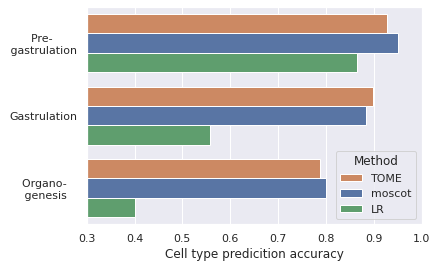

In [22]:
sns.barplot(data=DF, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln)
plt.xlim(0.3,1)
plt.ylabel('', fontsize=14)

Text(0, 0.5, '')

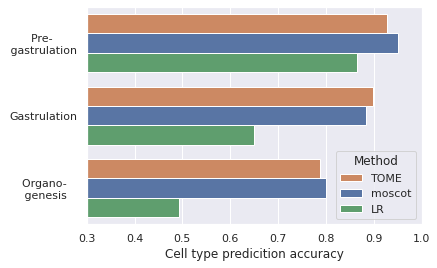

In [28]:
sns.barplot(data=DF, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln)
plt.xlim(0.3,1)
plt.ylabel('', fontsize=14)

In [10]:
DF2=pd.DataFrame({})

for i in range(3):
    df=[early, mid, end][i]
    
    if i==0:
        name='Pre-       \n gastrulation'
    elif i==1:
        name='Gastrulation'
    elif i==2:
        name='Organo-   \n genesis   '

    Dft=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df, 'germ')[0]],'Method':'TOME', 'timeframe':name})
    Dfm=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df,'germ')[1]],'Method':'moscot', 'timeframe':name})
    DF2=pd.concat([DF2, Dft, Dfm])
DF['timeframe']=DF2['timeframe']

In [11]:
DF2=pd.DataFrame({})

for i in range(3):
    df=[early, mid, end][i]
    
    if i==0:
        name='Pre-Gastrulation'
    elif i==1:
        name='Gastrulation   '
    elif i==2:
        name='Organogenesis '

    Dft=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df, 'germ')[0]],'Method':'TOME', 'timeframe':name})
    Dfm=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df,'germ')[1]],'Method':'moscot', 'timeframe':name})
    DF2=pd.concat([DF2, Dft, Dfm])
DF['timeframe']=DF2['timeframe']

In [12]:
DF2=pd.DataFrame({})

for i in range(3):
    df=[early, mid, end][i]
    
    if i==0:
        name='Pre-Gastrulation\n (E3.5 to E6.5) '
    elif i==1:
        name='Gastrulation   \n(E6.5 to E8.5)  '
    elif i==2:
        name='Organogenesis \n(E8.5 to E13.5) '

    Dft=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df, 'germ')[0]],'Method':'TOME', 'timeframe':name})
    Dfm=pd.DataFrame({'Cell type predicition accuracy': [calc_score(df,'germ')[1]],'Method':'moscot', 'timeframe':name})
    DF2=pd.concat([DF2, Dft, Dfm])
#DF['timeframe']=DF2['timeframe']

Text(0, 0.5, '')

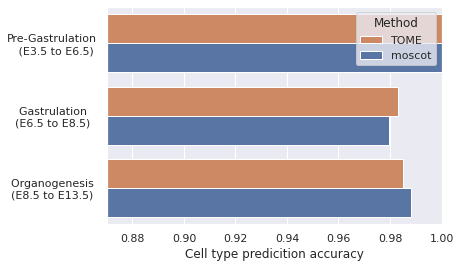

In [13]:
sns.barplot(data=DF2, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln)
plt.xlim(0.87,1)
plt.ylabel('', fontsize=14)

In [14]:
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


In [15]:
pal=sns.color_palette()
pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [16]:
pal=sns.color_palette()
paln=pal.copy()
paln[0]=pal[1]
paln[1]=pal[0]

In [17]:
paln[1]=np.array([13,111,178])/255
#paln[0]=np.array([230,115,25])/255

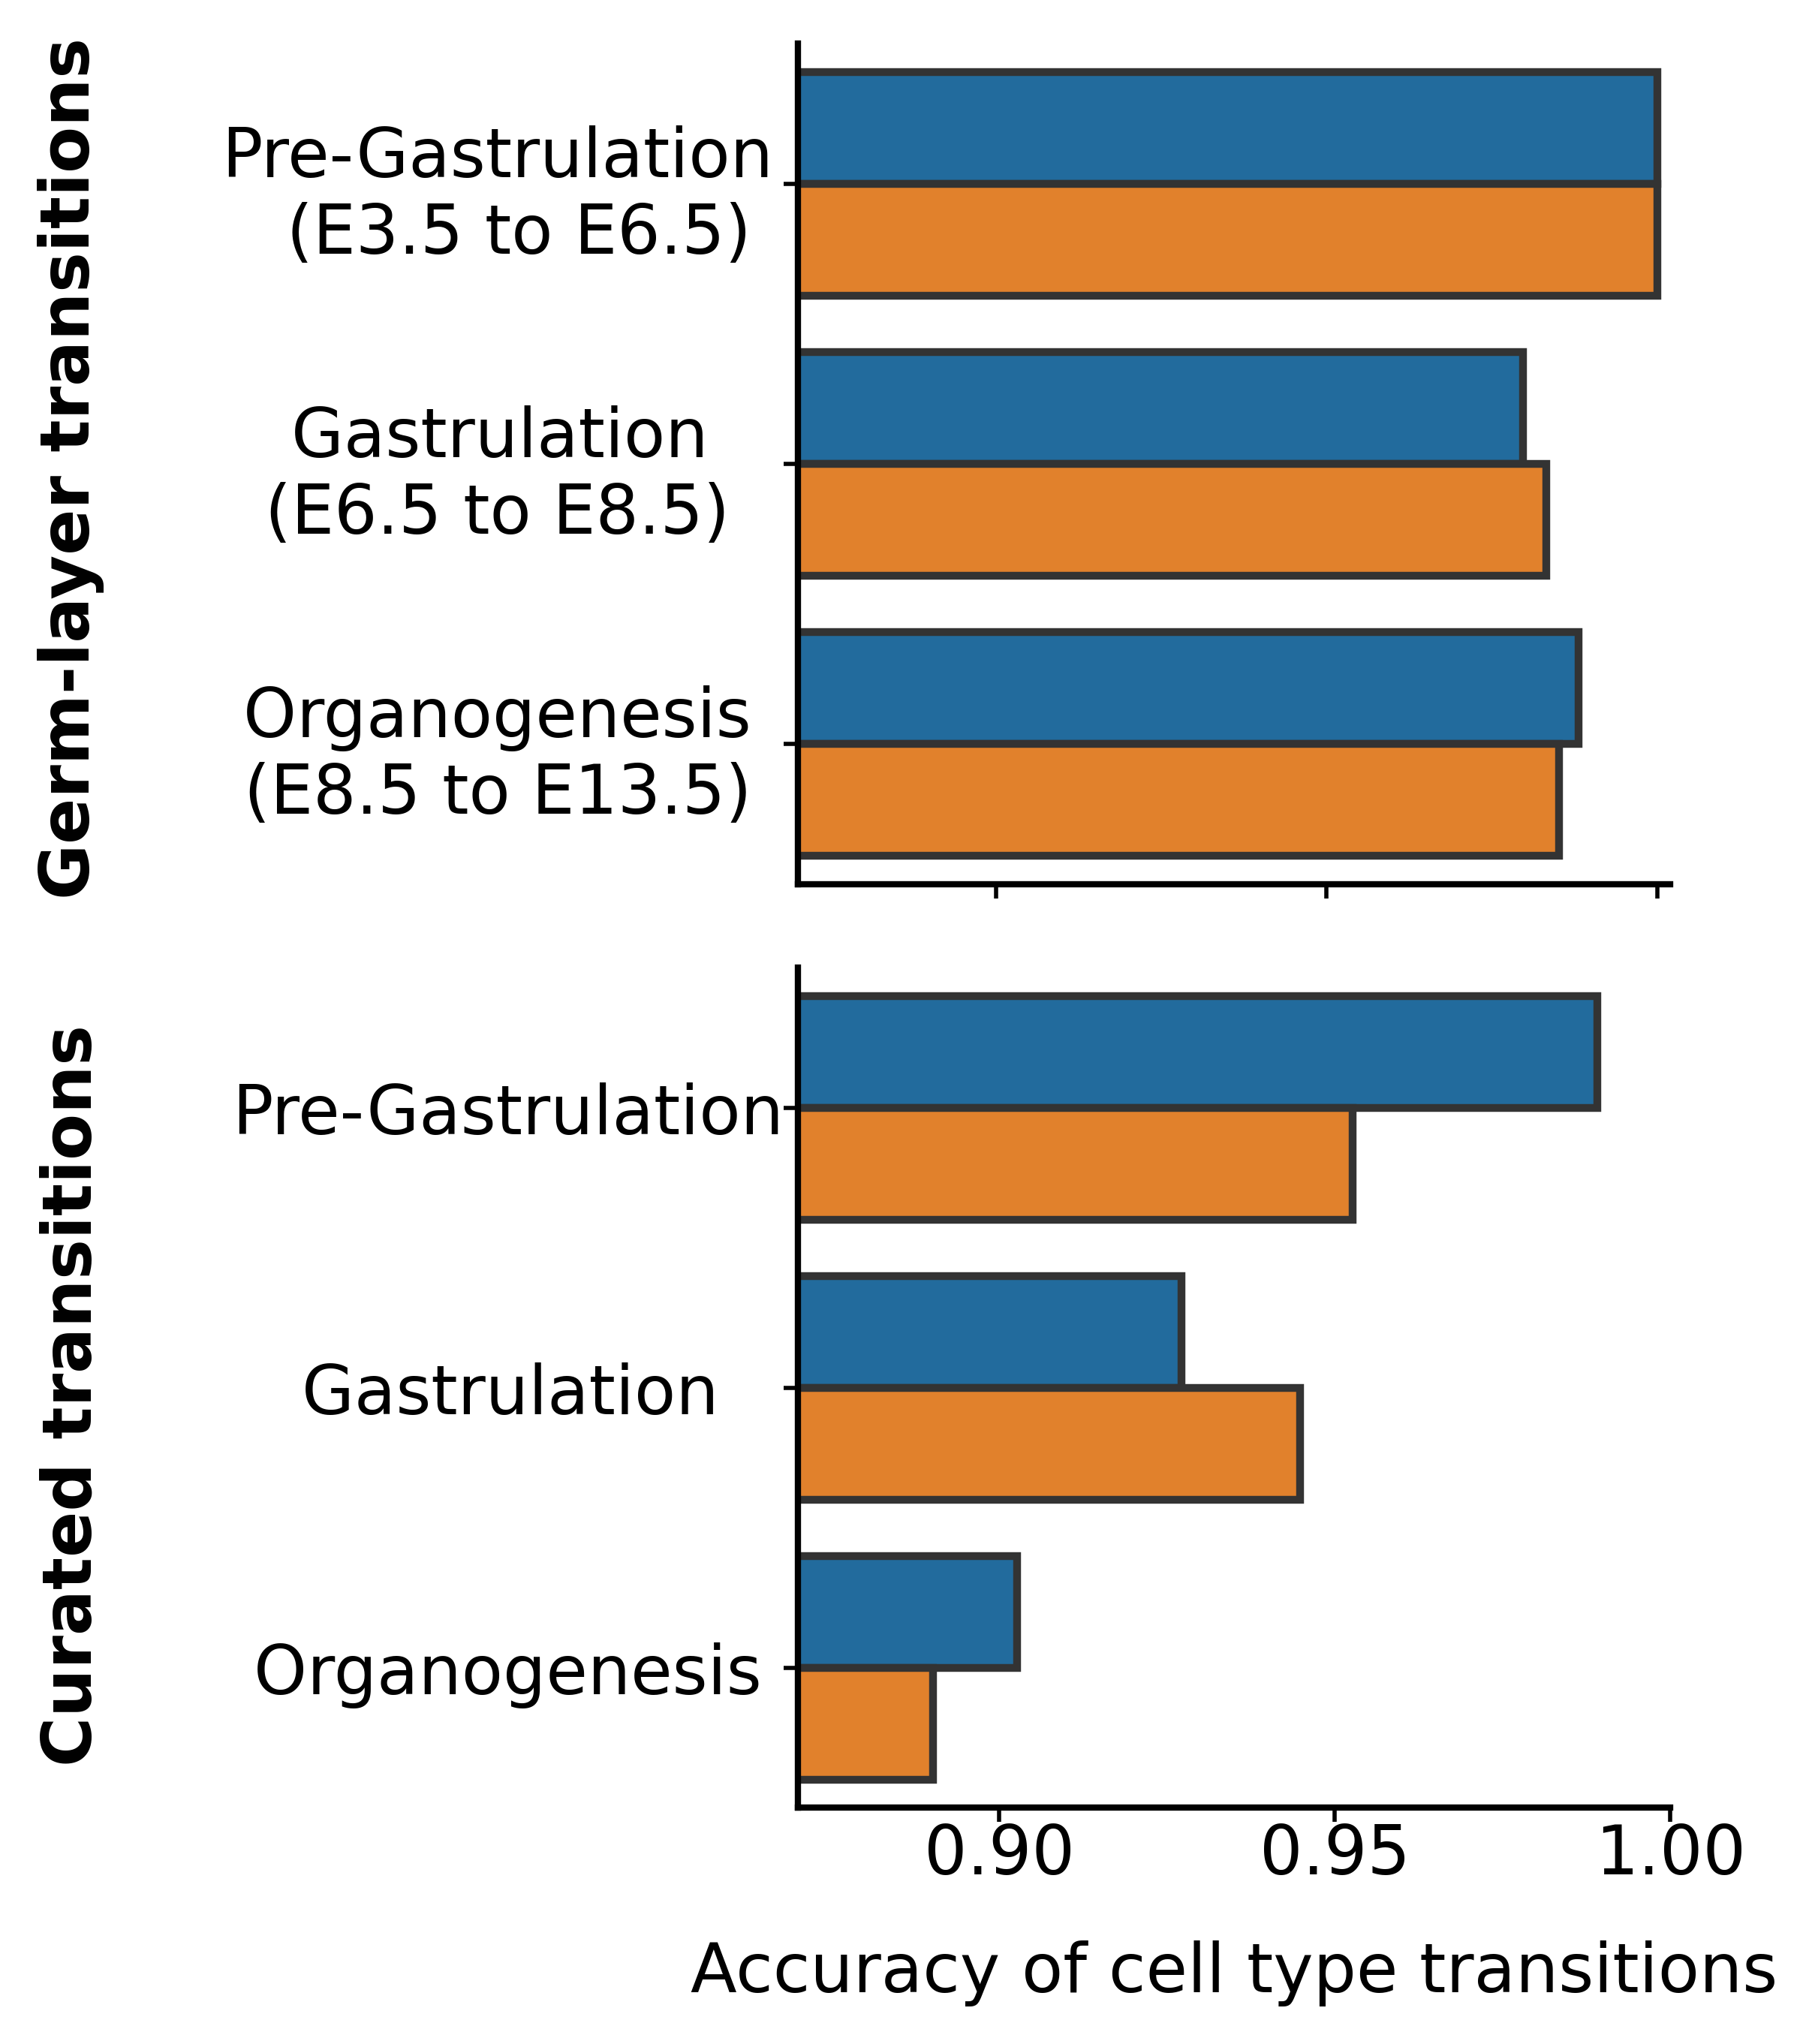

In [27]:
fontsize=13

fig, ax = plt.subplots(ncols=2, figsize=(3, 4.7), dpi=500)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.1)
g1=sns.barplot(data=DF2, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln,
               linewidth=1.5, edgecolor='0.2')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=12)
g1.legend_.remove()

plt.xlim(0.87,1.002)
plt.ylabel('', fontsize=fontsize)
plt.yticks(fontsize=fontsize, rotation='0')



#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
plt.text(x=0.755,y=2.5, s='Germ-layer transitions', rotation='vertical', color='black', fontsize=fontsize, weight="bold")


plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.barplot(data=DF, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln,
              linewidth=1.5, edgecolor='0.2')

plt.ylabel('', fontsize=fontsize)
plt.xlabel('Accuracy of cell type transitions', fontsize=fontsize, labelpad=10)


plt.text(x=0.757,y=2.3,s='Curated transitions', rotation='vertical', color='black', fontsize=fontsize, weight="bold")

g2.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)

#g2.tick_params(axis='x', pad=0)
#g2.tick_params(axis='y', pad=0)

plt.yticks(fontsize=fontsize, rotation='0')

plt.xlim(0.87,1)

plt.legend(fontsize=fontsize, loc='lower right')

xl=2.2
xr=3.6

#sns.move_legend(obj=g2, loc=(-0.12,-0.5), ncol=3, title_fontsize=14, fontsize=12)

#leg = plt.legend(loc=(0.7,0.1), title="$\\bf{Method}$", frameon=True)
#g2.add_artist(leg)
g2.legend_.remove()


#plt.text(x=0.82,y=-5.5,s='.', color='black', fontsize=0)


label0='Pre-Gastrulation: E3.5 to E6.5'
label1='  Gastrulation: E6.5 to E8.5'
label2='Organogenesis: E8.5 to E13.5'

#plt.text(x=0.82,y=-4.4,s=labels, color='white', fontsize=fontsize, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))


#plt.text(x=0.82,y=-5,s=label0, color='black', fontsize=fontsize)
#plt.text(x=0.82,y=-4.65,s=label1, color='black', fontsize=fontsize)
#plt.text(x=0.82,y=-4.3,s=label2, color='black', fontsize=fontsize)

# Change order - Moscot then TOME

In [19]:
DF2['sort']=[1 if a=='TOME' else 0 for a in DF2['Method']]
DF2=DF2.sort_values('sort').copy()
DF['sort']=[1 if a=='TOME' else 0 for a in DF['Method']]
DF=DF.sort_values('sort').copy()

In [20]:
pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [21]:
import mplscience
mplscience.set_style(reset_current=True)

pal=sns.color_palette()
paln=pal.copy()
paln[0]=np.array([13,111,178])/255

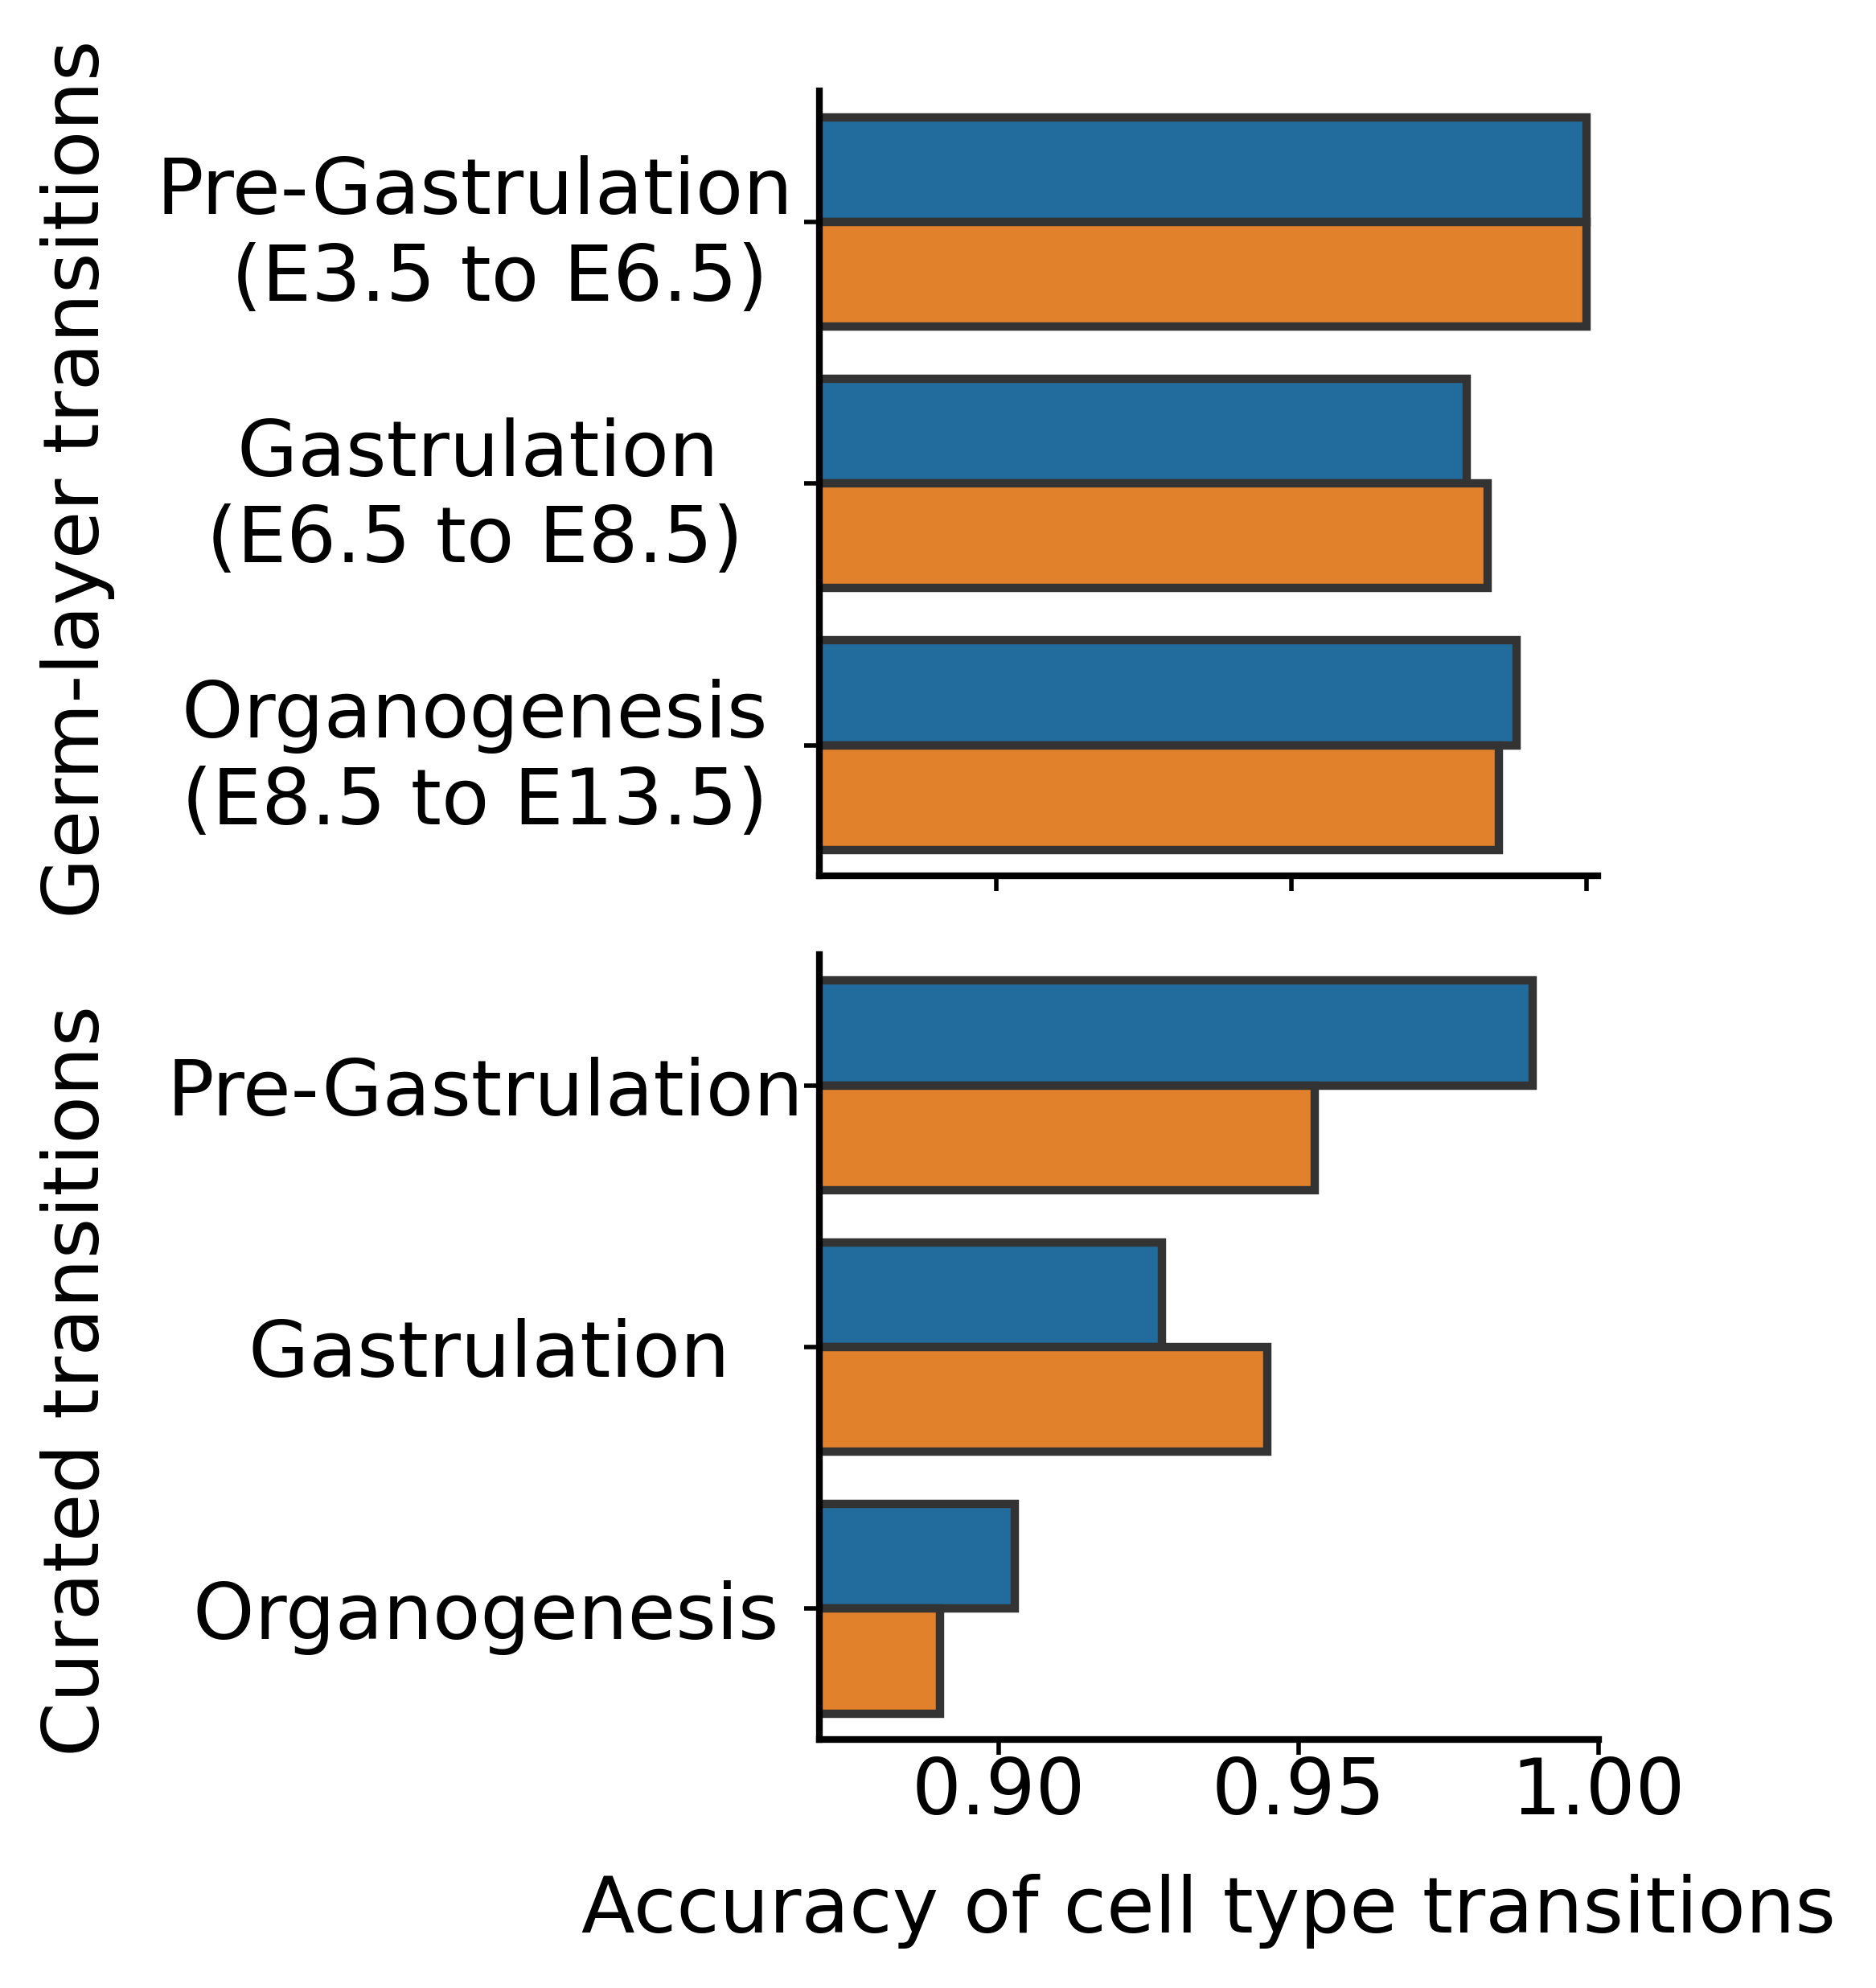

In [28]:
fontsize=14

fig, ax = plt.subplots(ncols=2, figsize=(2.5, 4.1), dpi=500)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.1)
g1=sns.barplot(data=DF2, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln,
               linewidth=1.5, edgecolor='0.2')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=12)
g1.legend_.remove()

plt.xlim(0.87,1.002)
plt.ylabel('', fontsize=fontsize)
plt.yticks(fontsize=fontsize, rotation='0')


#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
#plt.text(x=0.77,y=2.4, s='Germ-layer transitions', rotation='vertical', color='black', fontsize=fontsize)


plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.barplot(data=DF, x='Cell type predicition accuracy', y="timeframe",hue='Method', palette=paln,
              linewidth=1.5, edgecolor='0.2')

plt.ylabel('', fontsize=fontsize)
plt.xlabel('Accuracy of cell type transitions', fontsize=fontsize, labelpad=10)

plt.text(x=0.74,y=-0.7, s='Germ-layer transitions', rotation='vertical', color='black', fontsize=fontsize)
plt.text(x=0.74,y=2.5,s='Curated transitions', rotation='vertical', color='black', fontsize=fontsize)

g2.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)

#g2.tick_params(axis='x', pad=0)
#g2.tick_params(axis='y', pad=0)

plt.yticks(fontsize=fontsize, rotation='0')

plt.xlim(0.87,1)

plt.legend(fontsize=fontsize, loc='lower right')

xl=2.2
xr=3.6

#sns.move_legend(obj=g2, loc=(-0.12,-0.5), ncol=3, title_fontsize=14, fontsize=12)

leg = plt.legend(loc=(0.7,0.1), title="$\\bf{Method}$", frameon=True)
g2.add_artist(leg)
g2.xaxis.set_label_coords(0.5, -0.17)
sns.move_legend(obj=g2, loc=(0.65,0.07),  fontsize=fontsize, fancybox=True, frameon=True, title='')
g2.legend_.remove()


#plt.text(x=0.82,y=-5.5,s='.', color='black', fontsize=0)


label0='Pre-Gastrulation: E3.5 to E6.5'
label1='  Gastrulation: E6.5 to E8.5'
label2='Organogenesis: E8.5 to E13.5'

#plt.text(x=0.82,y=-4.4,s=labels, color='white', fontsize=fontsize, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))


#plt.text(x=0.82,y=-5,s=label0, color='black', fontsize=fontsize)
#plt.text(x=0.82,y=-4.65,s=label1, color='black', fontsize=fontsize)
#plt.text(x=0.82,y=-4.3,s=label2, color='black', fontsize=fontsize)

In [23]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [24]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [25]:
Df

,Starting Timepoint,t,eps,ap,cutoff,TOME_lit_c,TOME_lit_w,Moscot_lit_c,Moscot_lit_w,TOME_germ_c,TOME_germ_w,Moscot_germ_c,Moscot_germ_w
0,E3.5,3.50,0.00500,0.086152,0.1,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000
1,E4.5,4.50,0.00500,0.072651,0.1,3.851660,0.125926,3.919980,0.000000,3.977586,0.000000,3.919980,0.000000
2,E5.25,5.25,0.00500,0.079453,0.1,4.576487,0.238560,4.529644,0.128850,4.815047,0.000000,4.658494,0.000000
3,E5.5,5.50,0.00500,0.077491,0.1,4.661357,0.139159,4.825990,0.000000,4.800516,0.000000,4.825990,0.000000
4,E6.25,6.25,0.00500,0.094616,0.1,5.228518,0.555123,5.618083,0.112774,5.783641,0.000000,5.730856,0.000000
5,E6.5,6.50,0.00500,0.071265,0.1,6.781741,0.000000,6.828177,0.000000,6.781741,0.000000,6.828177,0.000000
6,E6.75,6.75,0.00500,0.070928,0.1,10.655545,0.000000,10.622619,0.000000,10.655545,0.000000,10.622619,0.000000
7,E7.0,7.00,0.00500,0.087297,0.1,14.245920,0.315465,14.305831,0.303884,14.561385,0.000000,14.609716,0.000000
8,E7.25,7.25,0.00500,0.097333,0.1,20.769611,2.334440,20.707968,2.309038,22.959390,0.144661,22.895164,0.121841
9,E7.5,7.50,0.00500,0.076733,0.1,23.149468,2.271894,22.579882,2.894856,24.272500,1.148863,24.139481,1.335257


In [26]:
Df[Df['Starting Timepoint']=='E7.0']

,Starting Timepoint,t,eps,ap,cutoff,TOME_lit_c,TOME_lit_w,Moscot_lit_c,Moscot_lit_w,TOME_germ_c,TOME_germ_w,Moscot_germ_c,Moscot_germ_w
7,E7.0,7.0,0.005,0.087297,0.1,14.24592,0.315465,14.305831,0.303884,14.561385,0.0,14.609716,0.0
